In [1]:
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_metric_learning import losses

np.random.seed(42)
torch.manual_seed(42)

Data preparation and loader

In [3]:
# def prepare_concept_arc_data(root_path):
#     X = []
#     Y = []
#     labels = []
#     for concept in os.listdir(root_path):
#         for task in os.listdir(os.path.join(root_path, concept)):
#             task_path = os.path.join(root_path, concept, task)
#             with open(task_path) as f:
#                 d = json.load(f)
#                 xs = []
#                 ys = []
#                 for example in d["train"]:
#                     x, y = example["input"], example["output"]
                    
#                     u = np.arange(10) # One-hot encoding of colors into 10 channels 
#                     x = (u[:,np.newaxis,np.newaxis]==x).astype(int)
#                     y = (u[:,np.newaxis,np.newaxis]==y).astype(int)

#                     xs.append(torch.tensor(x, dtype=torch.float64))
#                     ys.append(torch.tensor(y, dtype=torch.float64))
                
#                 X.append(xs)
#                 Y.append(ys)
#                 labels.append(concept)
    
#     le = LabelEncoder()
#     labels = le.fit_transform(labels)
#     return X, Y, np.array(labels)

# X, Y, labels = prepare_concept_arc_data("./corpus")

Train-Test split

In [4]:
# class ConceptArc(Dataset):
#     def __init__(self, X, Y, labels, mode):
#         self.X, self.Y, self.labels = X, Y, labels
#         self.mode = mode

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         label = self.labels[idx]
#         X = []
#         Y = []

#         channel_perm = np.random.permutation(np.arange(10))

#         for x, y in zip(self.X[idx], self.Y[idx]):
#             if self.mode == "train":
#                 x = x[channel_perm]
#                 y = y[channel_perm]

#                 ran1 = np.random.random_sample()
#                 if ran1 < 0.25: # 90* Rotation augmentation
#                     x = torch.rot90(x, k=1, dims=(1,2))
#                     y = torch.rot90(y, k=1, dims=(1,2))
#                 elif ran1 < 0.5: # 180* Rotation augmentation
#                     x = torch.rot90(x, k=2, dims=(1,2))
#                     y = torch.rot90(y, k=2, dims=(1,2))
#                 elif ran1 < 0.75: # 270* Rotation augmentation
#                     x = torch.rot90(x, k=3, dims=(1,2))
#                     y = torch.rot90(y, k=3, dims=(1,2))
                
#                 ran2 = np.random.random_sample()
#                 if ran2 < 0.5: # Transpose augmentation
#                     x = torch.transpose(x, 1, 2)
#                     y = torch.transpose(y, 1, 2)
                    
#             X.append(x)
#             Y.append(y)

#         return X, Y, label

In [ ]:
def prepare_arc_agi_data(root_path):

    with open("subset.txt", "r") as f:
        eval_subset = f.read().splitlines()

# "ARC-AGI/data/training"
    X = []
    Y = []
    for task in os.listdir(root_path):
        if task[:-5] in eval_subset: continue
        task_path = os.path.join(root_path, task)
        with open(task_path) as f:
            d = json.load(f)
            xs = []
            ys = []
            for example in d["train"]:
                x, y = example["input"], example["output"]
                
                u = np.arange(10) # One-hot encoding of colors into 10 channels 
                x = (u[:,np.newaxis,np.newaxis]==x).astype(int)
                y = (u[:,np.newaxis,np.newaxis]==y).astype(int)

                xs.append(torch.tensor(x, dtype=torch.float64))
                ys.append(torch.tensor(y, dtype=torch.float64))
            
            X.append(xs)
            Y.append(ys)
    
    return X, Y

X, Y = prepare_arc_agi_data("./ARC-AGI/data/training")

In [ ]:
class TaskDataset(Dataset):
    def __init__(self, X, Y):
        self.X, self.Y = X, Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = []
        Y = []

        channel_perm = np.random.permutation(np.arange(10))

        for x, y in zip(self.X[idx], self.Y[idx]):
            if self.mode == "train":
                x = x[channel_perm]
                y = y[channel_perm]

                ran1 = np.random.random_sample()
                if ran1 < 0.25: # 90* Rotation augmentation
                    x = torch.rot90(x, k=1, dims=(1,2))
                    y = torch.rot90(y, k=1, dims=(1,2))
                elif ran1 < 0.5: # 180* Rotation augmentation
                    x = torch.rot90(x, k=2, dims=(1,2))
                    y = torch.rot90(y, k=2, dims=(1,2))
                elif ran1 < 0.75: # 270* Rotation augmentation
                    x = torch.rot90(x, k=3, dims=(1,2))
                    y = torch.rot90(y, k=3, dims=(1,2))
                
                ran2 = np.random.random_sample()
                if ran2 < 0.5: # Transpose augmentation
                    x = torch.transpose(x, 1, 2)
                    y = torch.transpose(y, 1, 2)
                    
            X.append(x)
            Y.append(y)

        return X, Y

In [5]:
def my_collate(batch):
    X = [item[0] for item in batch]
    Y = [item[1] for item in batch]
    return [X, Y]


Models

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(10, 32, kernel_size=3, padding=1)
        # self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.dil_conv1 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2)
        # self.dil_conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2)

        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.relu = torch.nn.ReLU()

        self.linear = torch.nn.Linear(64*3, 64)

    def extract_features(self, x):
        x = x.type(torch.float)
        o1 = self.conv1(x)
        o2 = self.relu(o1)
        # o2 = self.conv2(o1)
        # o2 = self.relu(o2)

        o3 = self.dil_conv1(o2) + o2
        o4 = self.relu(o3)

        # o4 = self.dil_conv2(o3) + o3
        # o4 = self.relu(o4)

        o5 = self.conv3(o4)
        o5 = self.relu(o5)

        o6 = torch.cat([torch.mean(o5, dim=[1,2], keepdim=False), torch.amax(o5, dim=[1,2], keepdim=False), torch.amin(o5, dim=[1,2], keepdim=False)]) # (c, w, h) -> (2c)
        return o6

    def forward(self, X, Y):
        N = len(X)
        batch_transformation_output = []
        batch_xs_features = []
        for i in range(N):
            sample_out = None
            sample_xs = []
            for x, y in zip(X[i], Y[i]):
                x_features = self.extract_features(x)
                y_features = self.extract_features(y)

                sample_xs.append(x_features)

                if sample_out is None: sample_out = x_features - y_features
                else: sample_out += x_features - y_features

            sample_out = sample_out / (len(X[i]))
            
            batch_transformation_output.append(sample_out)
            batch_xs_features.append(sample_xs)

        batch_transformation_output = torch.stack(batch_transformation_output)
        batch_transformation_output = self.linear(batch_transformation_output)

        return batch_transformation_output, batch_xs_features
        

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(10, 32, kernel_size=3, padding=1)
        # self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.dil_conv1 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2)
        # self.dil_conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2)

        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.relu = torch.nn.ReLU()

    def extract_features(self, x):
        x = x.type(torch.float)
        o1 = self.conv1(x)
        o2 = self.relu(o1)
        # o2 = self.conv2(o1)
        # o2 = self.relu(o2)

        o3 = self.dil_conv1(o2) + o2
        o4 = self.relu(o3)

        # o4 = self.dil_conv2(o3) + o3
        # o4 = self.relu(o4)

        o5 = self.conv3(o4)
        o5 = self.relu(o5)

        o6 = torch.cat([torch.mean(o5, dim=[1,2], keepdim=False), torch.amax(o5, dim=[1,2], keepdim=False), torch.amin(o5, dim=[1,2], keepdim=False)]) # (c, w, h) -> (2c)
        return o6

    def forward(self, X, Y):
        N = len(X)
        batch_transformation_output = []
        batch_xs_features = []
        for i in range(N):
            sample_out = None
            sample_xs = []
            for x, y in zip(X[i], Y[i]):
                x_features = self.extract_features(x)
                y_features = self.extract_features(y)

                sample_xs.append(x_features)

                if sample_out is None: sample_out = x_features - y_features
                else: sample_out += x_features - y_features

            sample_out = sample_out / (len(X[i]))
            
            batch_transformation_output.append(sample_out)
            batch_xs_features.append(sample_xs)

        return torch.stack(batch_transformation_output), batch_xs_features
        

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.projection = Projection()
        self.classifier = Classifier()

    def set_mode(self, mode="contrastive"):
        if mode=="contrastive":
            for param in self.feature_extractor.parameters(): param.requires_grad = True
            for param in self.projection.parameters(): param.requires_grad = True
            for param in self.classifier.parameters(): param.requires_grad = False
        elif mode=="classification":
            for param in self.feature_extractor.parameters(): param.requires_grad = False
            for param in self.projection.parameters(): param.requires_grad = False
            for param in self.classifier.parameters(): param.requires_grad = True


    def forward(self, X, Y):
        features = self.feature_extractor(X, Y)
        projection = self.projection(features)
        logits = self.classifier(features)

        return projection, logits

In [9]:
def classification_accuracy(model, dataloader):
    with torch.no_grad():
        correct = [0] * ATTEMPTS
        total = 0
        for _, (X, Y, labels) in enumerate(dataloader):
            _, logits = model(X, Y)
            for attempt in range(ATTEMPTS):
                preds = logits.argsort(dim=1, descending=True)[:, :attempt+1]
                correct[attempt] += sum([int((labels[i]==preds[i]).any()) for i in range(len(labels))])
            
            total += len(labels)

        acc = [c/total for c in correct]
        return acc

def validation_loss(model, dataloader, classifier_criterion, contrastive_criterion):
    with torch.no_grad():
        total_loss = 0
        for i, (X, Y, labels) in enumerate(dataloader):
            projection, logits = model(X, Y)
            total_loss += contrastive_criterion(projection, labels).item()
            total_loss += classification_weight * classifier_criterion(logits, labels).item()

        return total_loss / len(dataloader)

In [10]:
def train_contrastive_classifier(model, train_dataloader, test_dataloader):
    classifier_criterion = torch.nn.CrossEntropyLoss()
    contrastive_criterion = losses.TripletMarginLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [[] for _ in range(ATTEMPTS)],
        "val_acc": [[] for _ in range(ATTEMPTS)],
    }

    best_model = model
    best_val_acc = [0]
    for epoch in range(300):

        running_loss = 0.0
        for i, (X, Y, labels) in enumerate(train_dataloader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            projection, logits = model(X, Y)
            loss = classification_weight*classifier_criterion(logits, labels) + contrastive_criterion(projection, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        # print statistics
        train_acc = classification_accuracy(model, train_dataloader)
        val_acc = classification_accuracy(model, test_dataloader)

        if val_acc[0] > best_val_acc[0]: # use top-1 classification for selecting best model, that's why 0th index
            best_model = model
            best_val_acc = val_acc
        # print(f'[{epoch + 1}, {i + 1}] loss: {running_loss/len(train_dataloader):.3f} val accuracy: {val_acc:.3f} train accuracy: {train_acc:.3f}')


        [history["train_acc"][i].append(train_acc[i]) for i in range(ATTEMPTS)]
        [history["val_acc"][i].append(val_acc[i]) for i in range(ATTEMPTS)]

        history["train_loss"].append(running_loss/len(train_dataloader))
        val_loss = validation_loss(model, test_dataloader, classifier_criterion, contrastive_criterion)
        history["val_loss"].append(val_loss)

    train_loss = history["train_loss"]
    val_loss = history["val_loss"]
    plt.plot(range(len(train_loss)), train_loss, label="train")
    plt.plot(range(len(val_loss)), val_loss, label="val")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    train_acc = history["train_acc"][0] # plot top-1 classification accuracy
    val_acc = history["val_acc"][0]

    plt.plot(range(len(train_acc)), train_acc, label="train")
    plt.plot(range(len(val_acc)), val_acc, color="orange", label="val")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")

    plt.legend()
    plt.show()

    # print('Finished Training')
    return best_model, best_val_acc

In [11]:
# train_loss = history["train_loss"]
# val_loss = history["val_loss"]
# plt.plot(range(len(train_loss)), train_loss, label="train")
# plt.plot(range(len(val_loss)), val_loss, label="val")
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.legend()
# plt.show()

In [12]:
# train_acc = history["train_acc"]
# val_acc = history["val_acc"]
# plt.plot(range(len(train_acc)), train_acc, label="train")
# plt.plot(range(len(val_acc)), val_acc, color="orange", label="val")
# plt.xlabel("epochs")
# plt.ylabel("accuracy")

# plt.legend()
# plt.show()

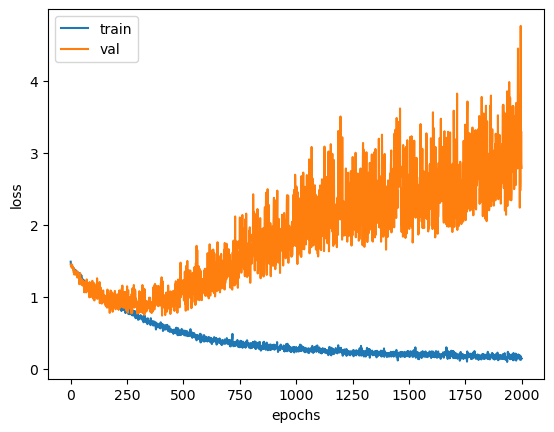

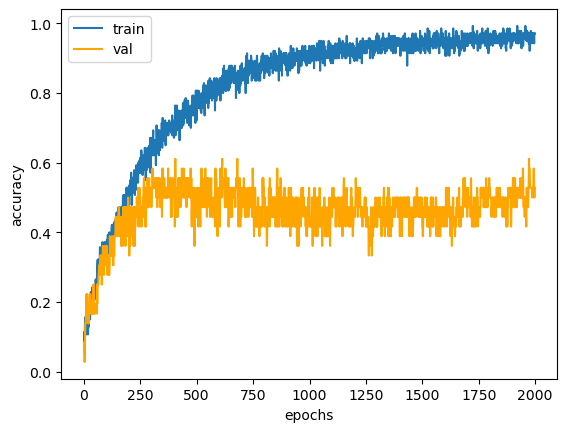

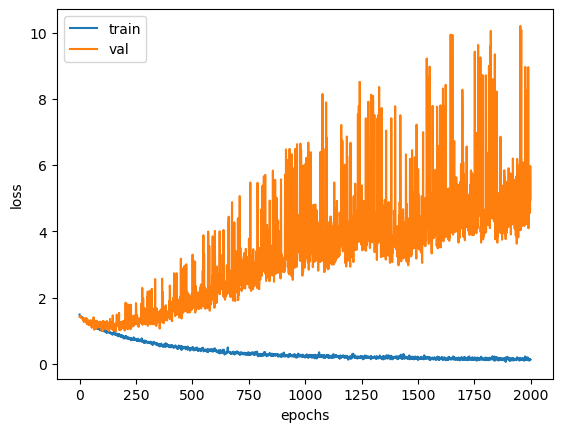

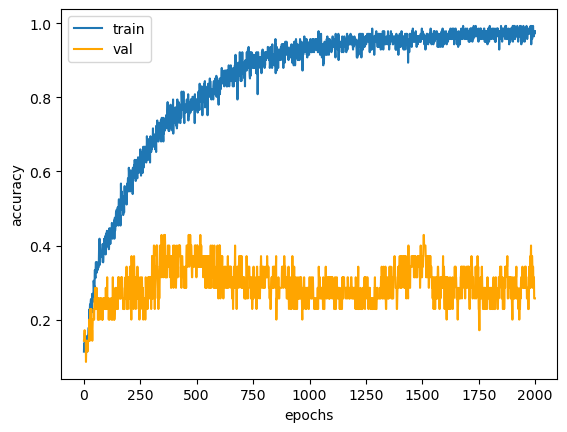

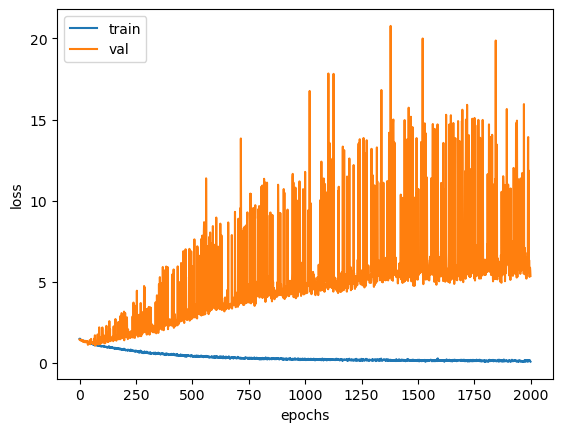

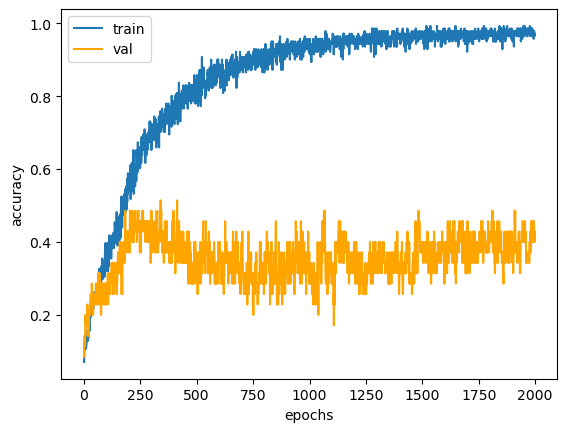

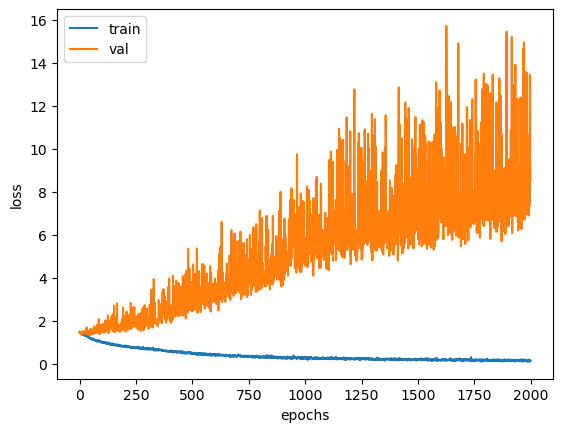

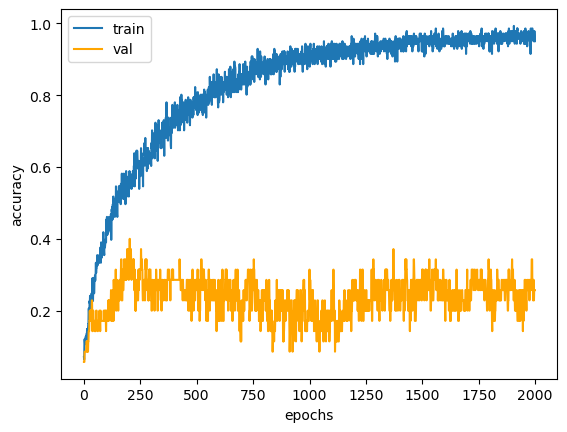

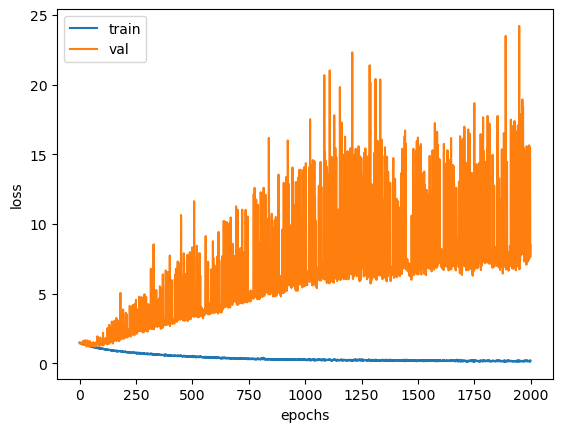

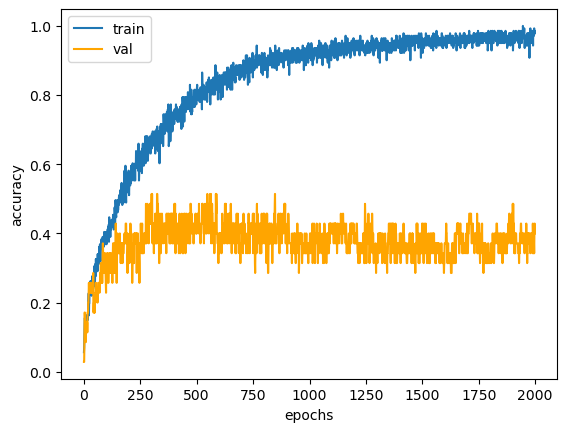

[[0.6111111111111112, 0.42857142857142855, 0.5142857142857142, 0.4, 0.5142857142857142], [0.6666666666666666, 0.5142857142857142, 0.5714285714285714, 0.4857142857142857, 0.5428571428571428], [0.7222222222222222, 0.6, 0.6, 0.5428571428571428, 0.6285714285714286], [0.75, 0.6857142857142857, 0.6571428571428571, 0.5714285714285714, 0.6571428571428571]] [0.4936507936507937, 0.5561904761904761, 0.6187301587301587, 0.6642857142857143]


In [13]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)

accs = [[] for _ in range(ATTEMPTS)]

models = []

for i, (train_index, test_index) in enumerate(skf.split(X, labels)):
    X_train, X_test = [X[idx] for idx in train_index], [X[idx] for idx in test_index]
    Y_train, Y_test = [Y[idx] for idx in train_index], [Y[idx] for idx in test_index]
    labels_train, labels_test = labels[train_index], labels[test_index]

    train_dataset = ConceptArc(X_train, Y_train, labels_train, "train")
    test_dataset = ConceptArc(X_test, Y_test, labels_test, "test")

    train_dataloader = DataLoader(train_dataset, batch_size=16,
                            shuffle=True, num_workers=0, collate_fn=my_collate)

    test_dataloader = DataLoader(test_dataset, batch_size=16,
                            shuffle=True, num_workers=0, collate_fn=my_collate)
    
    model = Model()
    best_model, best_val_acc = train_contrastive_classifier(model, train_dataloader, test_dataloader)
    models.append(best_model)
    [accs[i].append(best_val_acc[i]) for i in range(ATTEMPTS)]

print(accs, [sum(k_accs)/len(k_accs) for k_accs in accs])

In [14]:
for i, model in enumerate(models):
    torch.save(model.state_dict(), f"./concept-classifiers/{i}.pth")


12it [00:00, 40.24it/s]
/var/folders/1c/kbl_72tx4d960kspn1b5wr380000gn/T/ipykernel_13797/1060868958.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', N_CLASSES).colors


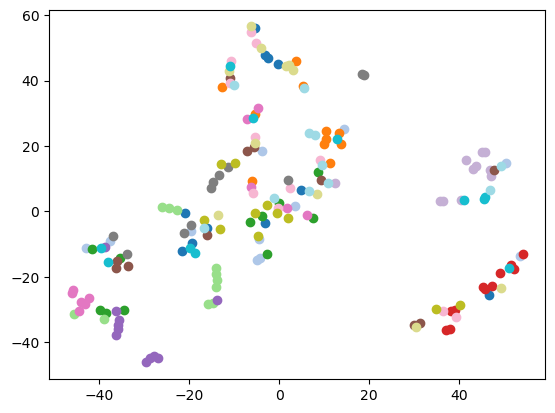

In [15]:
from sklearn.manifold import TSNE
def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v
            
projections = []
labels = []
with torch.no_grad():
    for i, (X, Y, lab) in tqdm(enumerate(itr_merge(train_dataloader, test_dataloader))):
        vec = None
        for model in models[:1]:
            with torch.no_grad():
                if vec is None:
                    vec = model.feature_extractor(X, Y)
                else:
                    vec += model.feature_extractor(X, Y)
        
        projections += [(v/len(models)).numpy() for v in vec]
        labels += lab

projections = np.array(projections)
labels = np.array(labels)

tsne = TSNE(n_components=2, learning_rate='auto', perplexity=3, random_state=42)
X_embedded = tsne.fit_transform(projections)

colors = plt.cm.get_cmap('tab20', N_CLASSES).colors

for class_label in range(N_CLASSES):
    plt.scatter(X_embedded[:,0][labels == class_label], X_embedded[:,1][labels == class_label], color=colors[class_label])

plt.show()